# Classical Equivalent Layer technique to perform an Reduction to the pole 

#### Importing libraries

In [1]:
% matplotlib inline 

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import datetime
import timeit
from scipy.optimize import nnls
from fatiando.gridder import regular
from fatiando.utils import ang2vec, vec2ang
from fatiando.mesher import Sphere, PointGrid,Prism
from fatiando.gravmag import sphere,prism
from fatiando.constants import CM, T2NT, G, SI2MGAL

/home/andrelreis/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [3]:
notebook_name = 'airborne_EQL_classical_RTP.ipynb'

### Gray background figures

In [4]:
plt.style.use('grayscale')

#### Importing auxiliary functions

In [5]:
dir_modules = '../../mypackage'
sys.path.append(dir_modules)

In [6]:
import auxiliary_functions as fc

#### Loading properties of the model

In [7]:
with open('data/model_poly_induced.pickle') as f:
        model_poly_induced = pickle.load(f)

In [8]:
with open('data/model_poly_remanent.pickle') as f:
        model_poly_remanent = pickle.load(f)

#### Loading properties grid

In [9]:
with open('data/airborne_survey.pickle') as f:
        airborne = pickle.load(f)

#### Loading data

In [10]:
with open('data/data_set.pickle') as f:
        data = pickle.load(f)

#### Open a dictionary

In [11]:
dir_poly = dict()

### Saving files

In [12]:
saved_files = []

## Observation area

In [13]:
print 'Area limits: \n x_max = %.1f m \n x_min = %.1f m \n y_max = %.1f m \n y_min = %.1f m' % (airborne['area'][1], 
                                                                                                airborne['area'][0],
                                                                                                airborne['area'][3],
                                                                                                airborne['area'][2])

Area limits: 
 x_max = 6000.0 m 
 x_min = -6000.0 m 
 y_max = 6000.0 m 
 y_min = -6000.0 m


### Airborne survey information

In [14]:
print 'Shape : (%.0f,%.0f)'% airborne['shape'] 
print 'Number of data: %.1f' % airborne['N']
print 'dx: %.1f m' % airborne['dx']
print 'dy: %.1f m ' % airborne['dy']

Shape : (50,30)
Number of data: 1500.0
dx: 244.9 m
dy: 413.8 m 


## Properties of the model

### Main field

In [15]:
inc_gf,dec_gf = model_poly_remanent['main_field']

In [16]:
print'Main field inclination: %.1f degree' % inc_gf
print'Main field declination: %.1f degree' % dec_gf

Main field inclination: 20.0 degree
Main field declination: 20.0 degree


### Magnetization direction

In [17]:
print 'Intensity: %.1f A/m' % model_poly_remanent['m']
print 'Inclination: %.1f degree' % model_poly_remanent['inc']
print 'Declination: %.1f degree' % model_poly_remanent['dec']

Intensity: 3.0 A/m
Inclination: 55.0 degree
Declination: 40.0 degree


In [18]:
inc_R,dec_R = model_poly_remanent['inc'],model_poly_remanent['dec']

## Generating the layer with my function 

In [19]:
h = 600.

#### Generating a layer

In [20]:
shape_layer = (airborne['shape'][0],airborne['shape'][1])

In [21]:
xs,ys,zs = regular(airborne['area'],shape_layer,h)

## Classical technique eqlayer

In [22]:
G = fc.sensitivity_mag(airborne['x'],airborne['y'],airborne['z'],
                       xs,ys,zs,inc_gf,dec_gf,49.,45.)

In [23]:
I = np.identity(airborne['shape'][0]*airborne['shape'][1])

In [24]:
mu = 1e-15

In [25]:
m_class = np.linalg.solve(np.dot(G.T,G)+ mu*I,np.dot(G.T,data['tfa_obs_poly_RM_airb']))

In [26]:
tf_pred = fc.tfa_layer(airborne['x'],airborne['y'],airborne['z'],
                           xs,ys,zs,inc_gf,dec_gf,m_class,49.,45.)

### Calculating residual

In [27]:
r_pos = data['tfa_obs_poly_RM_airb'] - tf_pred

#### Parameters for normalized histogram

In [28]:
r_norm,r_mean,r_std = fc.residual(data['tfa_obs_poly_RM_airb'],tf_pred)

In [29]:
print r_mean

-0.0200602129333


## Comparison between the Model and the Layer with posivity

/home/andrelreis/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


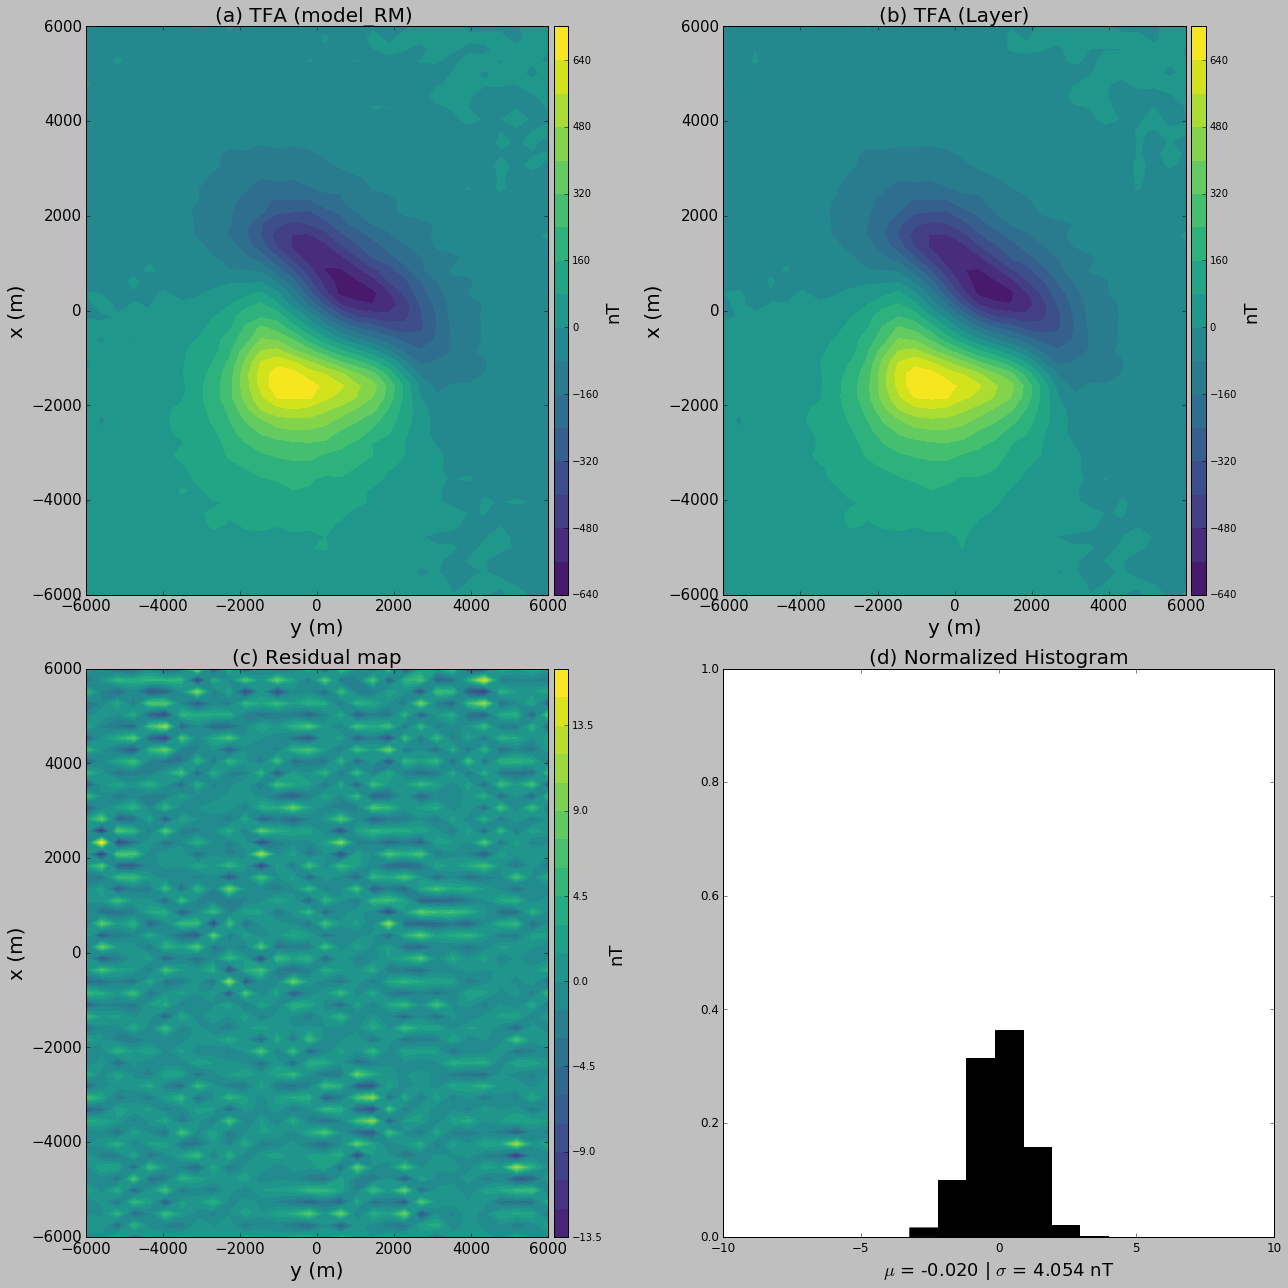

In [30]:
title_font = 20
bottom_font = 18
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(18,18), tight_layout=True)

ranges = saturation_factor*np.abs([data['tfa_obs_poly_RM_airb'].max(), 
                                   data['tfa_obs_poly_RM_airb'].min(),
                                   tf_pred.max(), tf_pred.min()]).max()

r_ranges = saturation_factor*np.abs([r_pos.max(), r_pos.min()]).max()


plt.subplot(2,2,1)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']), 
             data['tfa_obs_poly_RM_airb'].reshape(airborne['shape']),
             20, cmap='viridis',vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font) 
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(a) TFA (model_RM) ', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,2)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']),
             tf_pred.reshape(airborne['shape']),
             20, cmap='viridis',  vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(b) TFA (Layer)', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,3)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']),
             r_pos.reshape(airborne['shape']), 
             20, cmap='viridis',  vmin=-r_ranges, vmax=r_ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(c) Residual map', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=15)


plt.subplot(2,2,4)
plt.xlabel('$\mu$ = %.3f | $\sigma$ = %.3f nT' % (r_mean, r_std),
           fontsize = bottom_font)
nbins = int((np.max(r_norm - np.min(r_norm))))
plt.hist(r_norm,bins=nbins,normed=True)
plt.ylim(0.,1.)
plt.xlim(-10., 10.)
plt.title('(d) Normalized Histogram',fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

#file_name = 'figs/airborne/noisy_data_fitting_NNLS_magIM'
#plt.savefig(file_name+'.png',dpi=300)
#saved_files.append(file_name+'.png')

#plt.savefig(file_name+'.eps',dpi=300)
#saved_files.append(file_name+'.eps')

plt.show()

### Magnetic moment within the Layer with positivity constraint

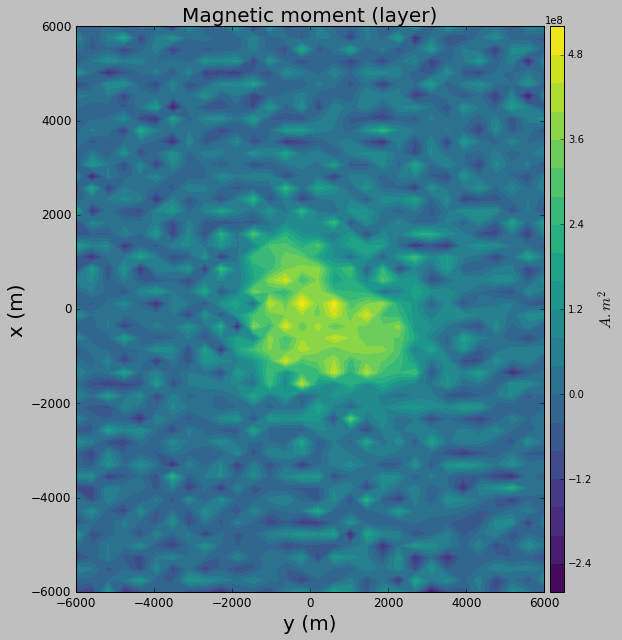

In [31]:
title_font = 20
bottom_font = 18
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(9,9), tight_layout=True)

plt.contourf(ys.reshape(shape_layer),xs.reshape(shape_layer), 
             m_class.reshape(shape_layer),20, cmap='viridis')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('$A.m^2$',size=15)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('Magnetic moment (layer)', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

#file_name = 'figs/airborne/noisy_magnetic_moment_positive_NNLS_magIM'
#plt.savefig(file_name+'.png',dpi=300)
#saved_files.append(file_name+'.png')

#plt.savefig(file_name+'.eps',dpi=300)
#saved_files.append(file_name+'.eps')

plt.show()

### Reduction to the pole

In [32]:
G_rtp = fc.sensitivity_mag(airborne['x'],airborne['y'],airborne['z'],
                       xs,ys,zs,90.,0.,90.,0.)

In [33]:
tfa_rtp = np.dot(G_rtp,m_class)

#### Visualization of a reduction to the pole

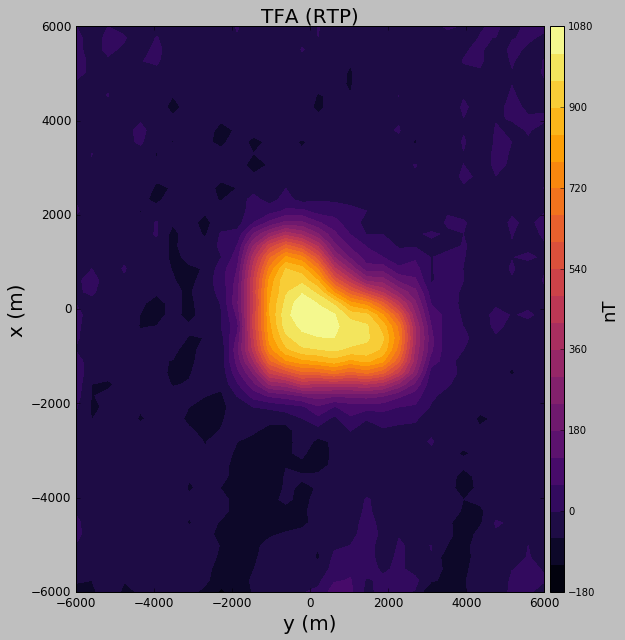

In [34]:
title_font = 20
bottom_font = 18
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(9,9), tight_layout=True)

plt.contourf(airborne['y'].reshape(airborne['shape']), 
             airborne['x'].reshape(airborne['shape']),
             tfa_rtp.reshape(airborne['shape']), 
             20, cmap='inferno')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('TFA (RTP)', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

#file_name = 'figs/airborne/RTP_airborne_magIM'
#plt.savefig(file_name+'.png',dpi=300)
#saved_files.append(file_name+'.png')

#plt.savefig(file_name+'.eps',dpi=300)
#saved_files.append(file_name+'.eps')

plt.show()

## Comparison between the RTP Calculated by equivalent layer and the true RTP field

In [35]:
r_rtp = tfa_rtp - data['tfa_obs_poly_IM_airb']

In [36]:
r_norm,r_mean,r_std = fc.residual(tfa_rtp,data['tfa_obs_poly_IM_airb'])

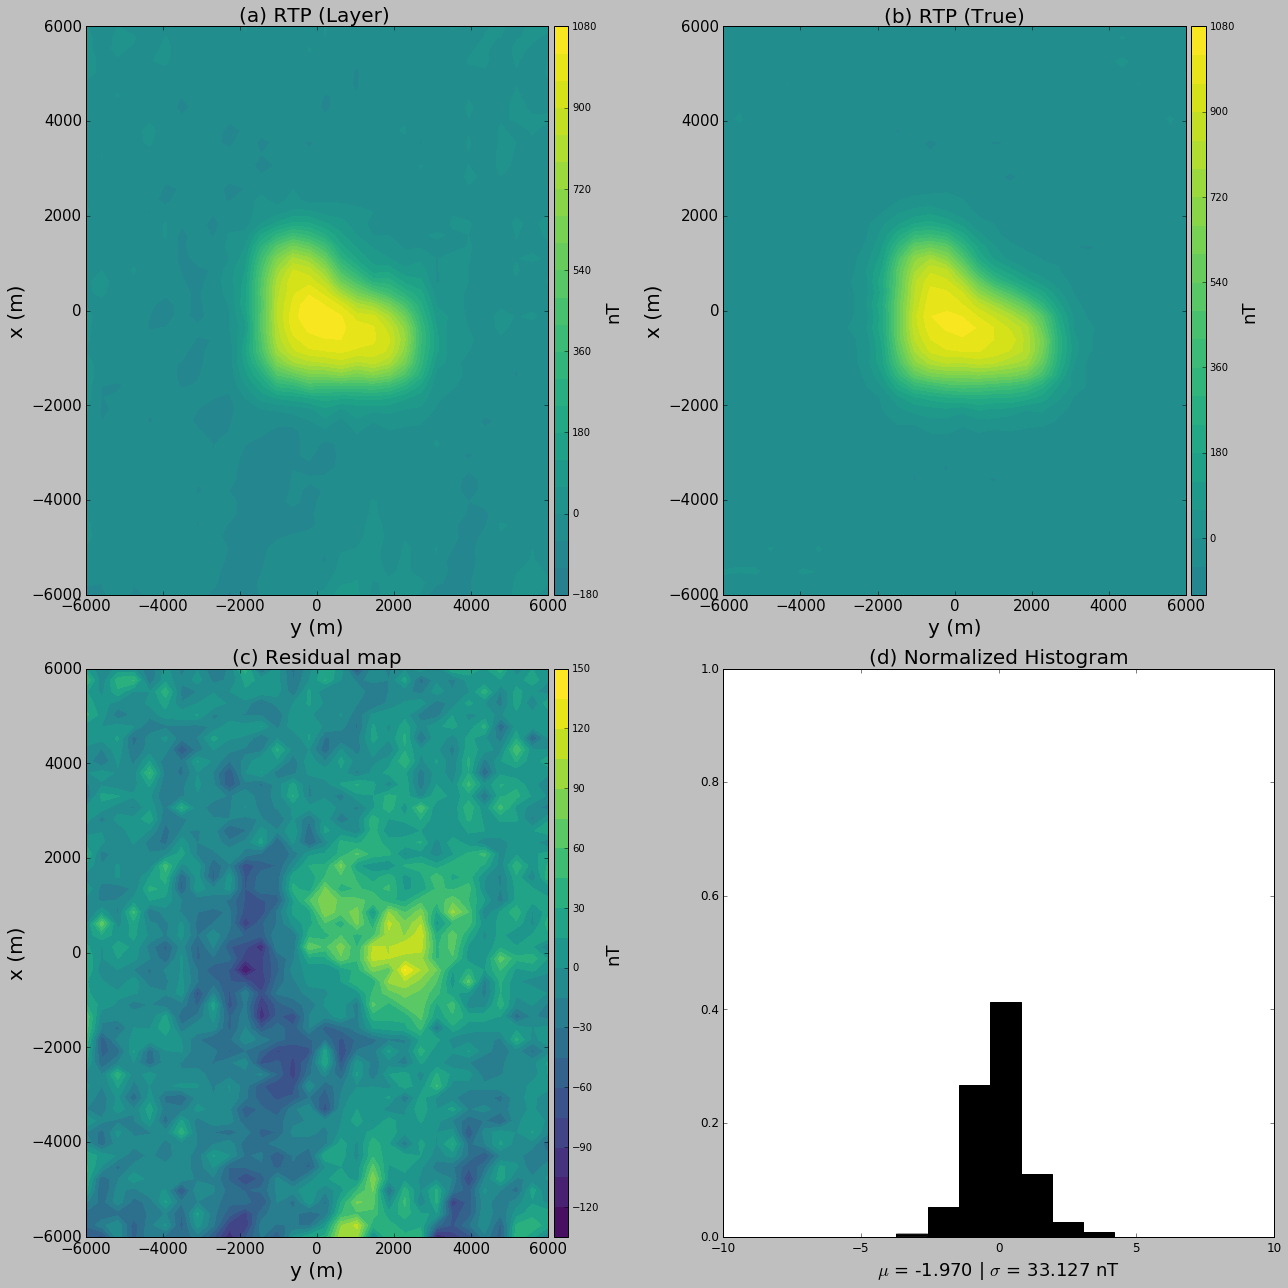

In [37]:
title_font = 20
bottom_font = 18
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(18,18), tight_layout=True)

ranges = saturation_factor*np.abs([tfa_rtp.max(), tfa_rtp.min(),
                                   data['tfa_obs_poly_IM_airb'].max(), data['tfa_obs_poly_IM_airb'].min()]).max()

r_ranges = saturation_factor*np.abs([r_rtp.max(), r_rtp.min()]).max()


plt.subplot(2,2,1)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']), 
             tfa_rtp.reshape(airborne['shape']),
             20, cmap='viridis',vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font) 
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(a) RTP (Layer) ', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,2)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']),
             data['tfa_obs_poly_IM_airb'].reshape(airborne['shape']),
             20, cmap='viridis',  vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(b) RTP (True)', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,3)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']),
             r_rtp.reshape(airborne['shape']), 
             20, cmap='viridis',  vmin=-r_ranges, vmax=r_ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(c) Residual map', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=15)


plt.subplot(2,2,4)
plt.xlabel('$\mu$ = %.3f | $\sigma$ = %.3f nT' % (r_mean, r_std),
           fontsize = bottom_font)
nbins = int((np.max(r_norm - np.min(r_norm))))
plt.hist(r_norm,bins=nbins,normed=True)
plt.ylim(0.,1.)
plt.xlim(-10., 10.)
plt.title('(d) Normalized Histogram',fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

#file_name = 'figs/airborne/rtp_layer_true'
#plt.savefig(file_name+'.png',dpi=300)
#saved_files.append(file_name+'.png')

#plt.savefig(file_name+'.eps',dpi=300)
#saved_files.append(file_name+'.eps')

plt.show()